<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Quick-OOP-tutorial-with-Jeremy" data-toc-modified-id="Quick-OOP-tutorial-with-Jeremy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Quick OOP tutorial with Jeremy</a></span></li><li><span><a href="#Collab-from-scratch" data-toc-modified-id="Collab-from-scratch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Collab from scratch</a></span><ul class="toc-item"><li><span><a href="#Why-this-is-interesting" data-toc-modified-id="Why-this-is-interesting-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Why this is interesting</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Code</a></span></li><li><span><a href="#Embedding-module-from-scratch" data-toc-modified-id="Embedding-module-from-scratch-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Embedding module from scratch</a></span></li><li><span><a href="#Interpreting-the-results" data-toc-modified-id="Interpreting-the-results-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Interpreting the results</a></span><ul class="toc-item"><li><span><a href="#Most-liked-movies-given-their-learned-factors-(kind-of-like-&quot;best-in-class&quot;)" data-toc-modified-id="Most-liked-movies-given-their-learned-factors-(kind-of-like-&quot;best-in-class&quot;)-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Most liked movies given their learned factors (kind of like "best in class")</a></span></li><li><span><a href="#What-did-the-model-learn-for-latent-factors?" data-toc-modified-id="What-did-the-model-learn-for-latent-factors?-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>What did the model learn for latent factors?</a></span></li></ul></li><li><span><a href="#Calculating-scores-with-an-NN-instead-of-a-dot-product" data-toc-modified-id="Calculating-scores-with-an-NN-instead-of-a-dot-product-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Calculating scores with an NN instead of a dot product</a></span></li></ul></li></ul></div>

# Quick OOP tutorial with Jeremy

The key idea in OOP is the **class**.

Classes I've already used:
- DataLoaders
- Learner
- str
- int
- torch.Tensor
- ...

A class:
- has data attached to it
- has functionality attached to it

Example class `Ex`:
- Data attached: `a`
- Functionality attached: `say()`

In [ ]:
class Ex:
    def __init__(self, a): self.a = a
    def say(self, x): return f'Hello {self.a}, {x}.'

Note on `__init__`:
- It's a special method
- Use it to set up any state which needs to be done upon object creation
- Any parameters included when the user constructs an instance of the class will be passed to the init method as parameters.

Example instance of class `Ex`: `ex1`
- the data 'Shmoopy' is stored in `a`

In [ ]:
ex1 = Ex('Shmoopy')
ex1.say('doop doop doop')

'Hello Shmoopy, doop doop doop.'

**Inheretance** is how we leverage pre-existing classes to make new classes that have all the same data and functionality, plus whatever new data and functionality I specify.

Example class that inherits from the fastai class `Module`. `Module` is the class used to define the functions that will serve as layers of a neural network, so here's a class that defines the dot product in a way we can use for building into nn's.
- torch docs for Module: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
- fastai docs for Module: https://docs.fast.ai/torch_core#Module

Jeremy says: "Forward is the most important torch method name." Instances of Modules are callable, and when called they run their `forward` method. So, since calling an instance of DotProduct will call DotProduct.forward(), we will codify the definition of dot product in its forward method.

In [ ]:
from fastai.torch_core import Module

class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors  = Embedding(n_users,  n_factors) # user_factors is an Embedding
        self.movie_factors = Embedding(n_movies, n_factors) # movie_factors is an Embedding
        
    def forward(self, x):
        # to grab the factors of an embedding, we call it like a function.
        # x is movie_ids and user_ids as two columns.
        users  = self.user_factors( x[:,0]) # pass in list of user ids
        movies = self.movie_factors(x[:,1]) # pass in list of movie ids
        return (users * movies).sum(dim=1)

# Collab from scratch

## Why this is interesting

Motivation:
- Given agents, events, and measurments (aka users, items, and scores), predict measurments for agent/event combos.
- Key concept: latent factors. We will create parameters that represent the latent factors of agents and events, then learn those factors. Predicting the score of an agent/event combo is reduced to a dot product of the agent's learned factors and the event's learned factors.

Design:
- Data: we're going to use the MovieLens dataset, which consists of Users, Movies, and Ratings (from 0 to 5).
- Arch: if users and movies have the same number of latent factors, we can take the dot product of user factors and movie factors to calculate predictions. No need to make a multi-layer model (this is NOT a nn).
- Loss: look up i-th user and j-th movie, calculate the dot product, then take the MSE between the result and the label. (RMSE and L1 are worth testing once everything is working and we're seeking marginal improvements).

Problem:
- EVERYTHING in the loss function MUST be something pytorch's autograd knows how to differentiate. How the F do you take the derivative of an index lookup?
- Innovation: an index lookup is equivalent to a matrix multiplication. Specifically: given a list of n items, looking up the i-th item is equivalent to multiplying the list by a one hot vector where the vector's i-th value is 1 (and the rest are 0).

## Code

ML_100k is a n=100k subset of the full 25m dataset.

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [ ]:
list(path.ls().sorted())

[Path('/home/rory/.fastai/data/ml-100k/README'),
 Path('/home/rory/.fastai/data/ml-100k/allbut.pl'),
 Path('/home/rory/.fastai/data/ml-100k/mku.sh'),
 Path('/home/rory/.fastai/data/ml-100k/u.data'),
 Path('/home/rory/.fastai/data/ml-100k/u.genre'),
 Path('/home/rory/.fastai/data/ml-100k/u.info'),
 Path('/home/rory/.fastai/data/ml-100k/u.item'),
 Path('/home/rory/.fastai/data/ml-100k/u.occupation'),
 Path('/home/rory/.fastai/data/ml-100k/u.user'),
 Path('/home/rory/.fastai/data/ml-100k/u1.base'),
 Path('/home/rory/.fastai/data/ml-100k/u1.test'),
 Path('/home/rory/.fastai/data/ml-100k/u2.base'),
 Path('/home/rory/.fastai/data/ml-100k/u2.test'),
 Path('/home/rory/.fastai/data/ml-100k/u3.base'),
 Path('/home/rory/.fastai/data/ml-100k/u3.test'),
 Path('/home/rory/.fastai/data/ml-100k/u4.base'),
 Path('/home/rory/.fastai/data/ml-100k/u4.test'),
 Path('/home/rory/.fastai/data/ml-100k/u5.base'),
 Path('/home/rory/.fastai/data/ml-100k/u5.test'),
 Path('/home/rory/.fastai/data/ml-100k/ua.base'),

The data we care about is in the u.data file (basically a csv). However, it's very sparse – instead of movie names, it only has movie IDs. Another file – u.item – is a map from movie ID to movie name.

We'll use dataframes to load up the csvs and merge the relevant fields into one final df of the integrated raw data.

In [ ]:
# look at ratings data (the meat)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
# look at movies data (just a list of id's and names)
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
# merge them (i want to see movie titles in the ratings data)
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


We can use fastai's built-ins to create a collab `dls` from a df.

In [ ]:
# dls
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,847,"Fish Called Wanda, A (1988)",4
1,276,Wag the Dog (1997),4
2,541,Jaws (1975),5
3,896,"Love Bug, The (1969)",2
4,459,Picture Perfect (1997),4
5,385,"Shining, The (1980)",3
6,758,Basic Instinct (1992),3
7,551,"Shining, The (1980)",4
8,198,Kingpin (1996),1
9,592,Wag the Dog (1997),4


In [ ]:
# number of users and movies (needed for param sizes but important to know)
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_users, n_movies

(944, 1665)

In [ ]:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [ ]:
# create dot product module with bias terms
from fastai.torch_core import Module

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors  = Embedding(n_users,  n_factors) # user_factors is an Embedding
        self.movie_factors = Embedding(n_movies, n_factors) # movie_factors is an Embedding
        self.user_bias     = Embedding(n_users,  1) # single bias term
        self.movie_bias    = Embedding(n_movies, 1) # single bias term
        self.y_range = y_range
        
    def forward(self, x):
        # to grab the factors of an embedding, we call it like a function.
        # x is movie_ids and user_ids as two columns.
        u_factors = self.user_factors( x[:,0]) # pass in list of user ids
        m_factors = self.movie_factors(x[:,1]) # pass in list of movie ids
        res = (u_factors * m_factors).sum(dim=1, keepdim=True) #? what does keepdim do?
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1]) # add bias terms to result
        return sigmoid_range(res, *self.y_range)

In [ ]:
# train
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.937822,0.949890,00:04
1,0.865991,0.864929,00:04
2,0.737443,0.825173,00:04
3,0.588841,0.814564,00:04
4,0.491690,0.815076,00:04


In [ ]:
(0.815076**2)/5

0.13286977715520001

## Embedding module from scratch

An embedding layer is the thing that we index into. Pretty simple! We just need to Abide By The Rules of Pytorch, which in this case means wrapping the parameter matrix in `nn.Parameter()`. That tells pytorch to optimize whatever it wraps in the stepper.

In [ ]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0.00, 0.01))

Make sure that works..:

In [ ]:
x = create_params([2,2]); x[1][1]

tensor(0.0013, grad_fn=<SelectBackward>)

Great! Wasn't that simple? Last step is to rewrite my module to use create_params:

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_films, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.film_factors = create_params([n_films, n_factors])
        self.user_bias    = create_params([n_users])
        self.film_bias    = create_params([n_films])
        self.y_range      = y_range
        
    def forward(self, xb):                   # xb is a batch of (user_ids, title_ids)
        user_fs = self.user_factors[xb[:,0]] # t[rows,cols]; t[:,0] → all rows, col 0
        film_fs = self.film_factors[xb[:,1]] # index into factors with list of id's
        scores  = (user_fs*film_fs).sum(dim=1)
        scores += self.user_bias[xb[:,0]] + self.film_bias[xb[:,1]]
        return sigmoid_range(scores, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.973473,0.940576,00:05
1,0.841698,0.866507,00:05
2,0.728830,0.824827,00:05
3,0.592366,0.814221,00:05
4,0.481735,0.814645,00:05


## Interpreting the results

### Most liked movies given their learned factors (kind of like "best in class")

Looking at the learned user biases will tell us who the most "optimistic" and "pessimistic" users are. Looking at the movie bias terms will tell us which movies are best-in-class (first) and worst-in-class (second):

In [ ]:
movie_bias = learn.model.film_bias.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['As Good As It Gets (1997)',
 'Shawshank Redemption, The (1994)',
 'Good Will Hunting (1997)',
 'Titanic (1997)',
 'Silence of the Lambs, The (1991)']

In [ ]:
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Cable Guy, The (1996)',
 'Big Bully (1996)',
 'Mortal Kombat: Annihilation (1997)']

Something must be wrong because I thought that Cable Guy was amazing. Anyway... 

### What did the model learn for latent factors?

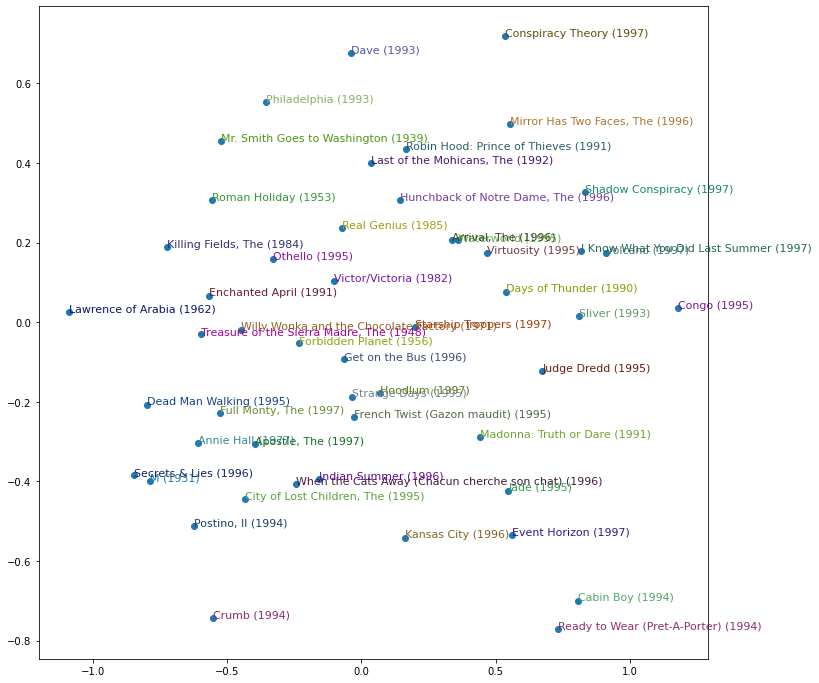

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.film_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
f0,f1,f2 = movie_pca.t()
idxs = np.random.choice(len(top_movies), 50, replace=False)
X = f0[idxs]
Y = f1[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i,x,y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*.7, fontsize=11)
plt.show()

- Far-left looks like adult films (& critically acclaimed), far-right looks like family films.
- Not sure what top/bottom looks like here.

"No matter how many models I train, I never stop getting moved and surprised by how these randomly initialized bunches of numbers, trained with such simple mechanics, manage to discover things about my data all by themselves. It almost seems like cheating, that I can create code that does useful things without ever actually telling it how to do those things!" 

\- J.H.

## Calculating scores with an NN instead of a dot product

In [ ]:
embs = get_emb_sz(dls)
embs # [(n_users, suggested n_user_factors), (...same for movies...)]

[(944, 74), (1665, 102)]

In [ ]:
tensor(embs)[:,1].max().item()

102

In [ ]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, xb): # xb is a batch of (user_ids, title_ids)
        embs = self.user_factors(xb[:,0]), self.item_factors(xb[:,1]) # get the b's factors
        xb   = self.layers(torch.cat(embs, dim=1)) # concat and pass through the nn
        return sigmoid_range(xb, *self.y_range)

In [ ]:
model = CollabNN(*embs)

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.930791,0.937979,00:05
1,0.918620,0.904008,00:05
2,0.880209,0.872466,00:05
3,0.815806,0.854171,00:05
4,0.762827,0.854791,00:05


Not bad! Not as good as the dot product, but this may be better for different models.

In [ ]:
doc(EmbeddingNN)

EmbeddingNN(emb_szs, layers, ps=None, embed_p=0.0, y_range=None, use_bn=True, bn_final=False, bn_cont=True, act_cls=ReLU(inplace=True))
Subclass `TabularModel` to create a NN suitable for collaborative filtering.

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


In [ ]:
class EmbeddingNN(TabularModel):
    "Subclass `TabularModel` to create a NN suitable for collaborative filtering."
    @delegates(TabularModel.__init__)
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs=emb_szs, n_cont=0, out_sz=1, layers=layers, **kwargs)